In [1]:
import cv2
import math
import copy
import numpy as np
from skimage import measure
from scipy.interpolate import splprep, splev
from scipy import optimize, ndimage
import matplotlib.pyplot as plt
from scipy.integrate import simps
from skimage import filters, feature, morphology

### 1. Load the chromophobe-renal-cell-carcinoma image

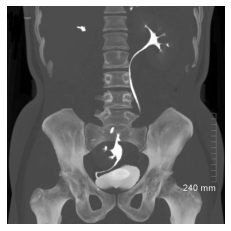

In [2]:
renalcell_img = cv2.imread('chromophobe-renal-cell-carcinoma-6.jpg', 0)
## disable x & y axis
plt.axis('off')
plt.imshow(renalcell_img, cmap='gray', vmin=renalcell_img.min(), vmax=renalcell_img.max())

### 2. Design an interface to obtain the initial contour from user's clicks

In [3]:
renalcell_points = []  
renalcell_img_copy = copy.deepcopy(renalcell_img)

In [4]:
def mouse_click(event, x, y, flags, params):
    # Check whether left mouse button was clicked
    if event == cv2.EVENT_LBUTTONDOWN:
        cv2.circle(params[0], (x, y), 5, (255, 0, 0), -1)
        cv2.imshow(params[1], params[0])
        params[2].append([x, y])
        print(params[2])

In [5]:
cv2.namedWindow('Renal Cell Image')
cv2.setMouseCallback('Renal Cell Image', mouse_click, (renalcell_img_copy, 'Renal Cell Image', renalcell_points))

### Press q when you are done with locating the points of the initial contour

In [7]:
while True:
    cv2.imshow('Renal Cell Image', renalcell_img_copy)
    # cv2.waitKey(1)

    key = cv2.waitKey(1) & 0xFF
    if key == ord('q'):  # Press 'q' to exit
        break
    
cv2.destroyAllWindows()
    

[[312, 56]]
[[312, 56], [283, 76]]
[[312, 56], [283, 76], [289, 115]]
[[312, 56], [283, 76], [289, 115], [322, 137]]
[[312, 56], [283, 76], [289, 115], [322, 137], [382, 106]]
[[312, 56], [283, 76], [289, 115], [322, 137], [382, 106], [379, 49]]
[[312, 56], [283, 76], [289, 115], [322, 137], [382, 106], [379, 49], [343, 39]]


In [30]:
renalcell_points = np.array(renalcell_points)
renalcell_points

array([[312,  56],
       [283,  76],
       [289, 115],
       [322, 137],
       [382, 106],
       [379,  49],
       [312,  56]])

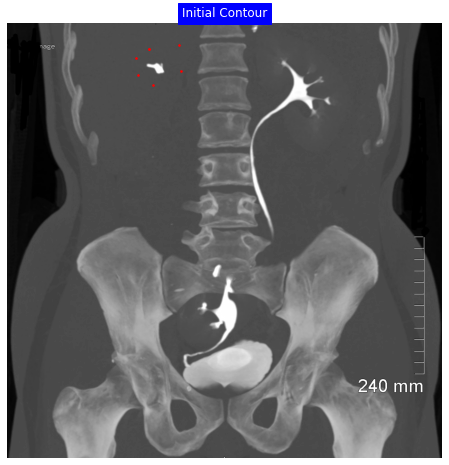

In [39]:
fig, ax = plt.subplots(figsize=(18, 8))
## disable x & y axis
ax.axis('off')
plt.title('Initial Contour', color='white', backgroundcolor='blue')
ax.imshow(renalcell_img, cmap='gray')
ax.scatter(renalcell_points[:, 0], renalcell_points[:, 1], marker=".", color="red", s=10)
plt.show()

### Convert the initial contour points located by user, to a set of 2D points that are equally spaced along the object's contour.

In [40]:
def equally_spaced_boundary_pts(initial_points, pt_spacing=10):
    # interpolate boundary
    tck, u = splprep(initial_points.T, u=None, s=0.0, per=1)
    u_new = np.linspace(u.min(), u.max(), 1000)
    x_new, y_new = splev(u_new, tck, der=0)

    # get equi-spaced points along spline-interpolated boundary
    x_diff, y_diff = np.diff(x_new), np.diff(y_new)
    S = simps(np.sqrt(x_diff**2 + y_diff**2))
    N = int(round(S/pt_spacing))

    u_equidist = np.linspace(0, 1, N+1)
    x_equidist, y_equidist = splev(u_equidist, tck, der=0)
    return np.array(list(zip(x_equidist, y_equidist)))

In [44]:
boundary_pts = equally_spaced_boundary_pts(renalcell_points, pt_spacing=5)

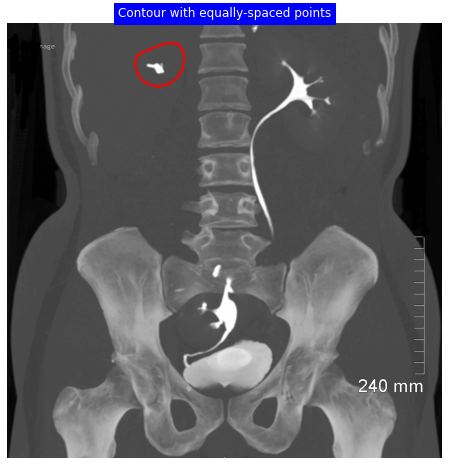

In [45]:
fig, ax = plt.subplots(figsize=(18, 8))
## disable x & y axis
ax.axis('off')
plt.title('Contour with equally-spaced points', color='white', backgroundcolor='blue')
ax.imshow(renalcell_img, cmap='gray')
ax.scatter(boundary_pts[:, 0], boundary_pts[:, 1], marker=".", color="red", s=10)
plt.show()